In [1]:
# main objective is to plot heatmap of nandata

In [2]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain

In [3]:
NumBins = 6
NumHarms = 4
rca_comp = 0

In [4]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_Fx_OutputData\\RCA_Files\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[2]#d[1] # choose one
FileN_f2  = d[4]# d[3]                         
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

file_path2 = os.path.join(MainDir, FileN_f2) # join paths and prep 2 load
print('Current WD:',file_path2) # does path exist ... ?
print('Does File #2 Exist?',os.path.exists(file_path1)) # yes or no

Avilable Files to choose from: 5
Files on hand: ['desktop.ini', 'OfficialF1_Control_rcaResults_Sweep.mat', 'OfficialF1_rcaResults_Sweep_F2F4F6F8.mat', 'OfficialF2_Control_rcaResults_Sweep.mat', 'OfficialF2_rcaResults_Sweep_F2F4F6F8.mat']
Current WD: C:\plimon\LTP_analysis\RCA_Fx_OutputData\RCA_Files\OfficialF1_rcaResults_Sweep_F2F4F6F8.mat
Does File #1 Exist? True
Current WD: C:\plimon\LTP_analysis\RCA_Fx_OutputData\RCA_Files\OfficialF2_rcaResults_Sweep_F2F4F6F8.mat
Does File #2 Exist? True


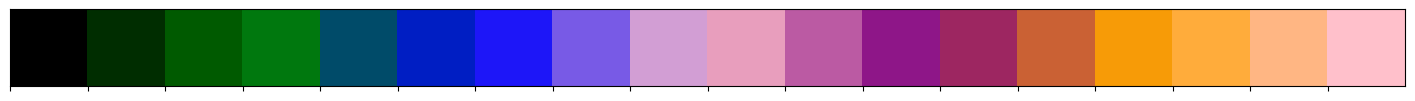

In [5]:
# Define the base colors for blending
base_colors = ['black','green', 'blue', 'pink', 'purple', 'orange', 'pink']
# Number of colors needed in the spectrum
num_colors = 18
fill = sns.blend_palette(base_colors, n_colors=num_colors, as_cmap=False)
sns.palplot(fill)
plt.show()

In [6]:
df_f1 = scipy.io.loadmat(file_path1)
df_f2 = scipy.io.loadmat(file_path2)

In [7]:
rca_f1 = df_f1['rcaResult']['projectedData'][0,0]
f1 = [rca_f1[x,0] for x in range(rca_f1.shape[0])] # entry per subject

F1_noise = df_f1['rcaResult']['noiseData'][0,0]
noise_f1 = [F1_noise[x,0] for x in range(F1_noise.shape[0])][0][1]# entry per subject

In [8]:
rca_f2 = df_f2['rcaResult']['projectedData'][0,0]
f2 = [rca_f2[x,0] for x in range(rca_f2.shape[0])]

F2_noise = df_f2['rcaResult']['noiseData'][0,0]
noise_f2 = [F2_noise[x,0] for x in range(F2_noise.shape[0])][0][1]# entry per subject

In [9]:
# load subject names ...
SubNames = df_f1['rcaResult'][0,0][5]
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]] # rm 'nl-'
#FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
UniformFileNames = [str(s).replace('-', '_') for s in FileName]
print(f'Total Data Files: {len(FileName)}')

Total Data Files: 66


In [10]:
NumFiles = int(len(FileName))
print(NumFiles)

66


In [11]:
File_Split_CatchString = '_'
SubjectNum_Array = [x.split(File_Split_CatchString)[0] for x in UniformFileNames]
SubjExpCo = [x.split(File_Split_CatchString)[1] for x in UniformFileNames]

In [12]:
AllSubject_IDs, SessionsCompleted = np.unique(np.array(SubjectNum_Array), return_counts = True)

print(f'all participants: {len(AllSubject_IDs)}')

print(f'Complete Files: {np.sum(SessionsCompleted[SessionsCompleted == 2])/2}')
print(f'Single Session Files: {np.sum(SessionsCompleted[SessionsCompleted == 1])}')

all participants: 38
Complete Files: 28.0
Single Session Files: 10


### *Get Subject File Postions*

In [13]:
Subject_File_LocNums = np.zeros(((int((len(AllSubject_IDs)))),2))
subList_int = [int(x) for x in SubjectNum_Array]

for sub_file_pos in range(len(AllSubject_IDs)):
    Single_Subj_ID = AllSubject_IDs[sub_file_pos]

    # find all locations where subj ID appears - 2x MAX (2 sessions)
    Get_Sub_Positions = [i for i, x in enumerate(subList_int) if x == int(Single_Subj_ID)]

    # 1st session label
    Position_Determiner = SubjExpCo[Get_Sub_Positions[0]] # first session expt label

    if Position_Determiner == 'attnR2': # 1 subj did 2 attnR expts so nan then out for rn 
        #print(f'same session 2x mishap .. nanning ..')
        Subject_File_LocNums[sub_file_pos,:] = np.nan
    else: 
        Subject_File_LocNums[sub_file_pos,:] = Get_Sub_Positions

    # we could stop here,,,but single files exist ;-;

    if len(Get_Sub_Positions) == 1: # if one file was located only, we need to know what session was completed
       #print(f'only 1 file found')
       Position_Determiner = SubjExpCo[Get_Sub_Positions[0]] # get expt label for only file from subject 
       if Position_Determiner == 'attnL':
            print(f'only attnL session exists')
            Subject_File_LocNums[sub_file_pos,0] = Get_Sub_Positions[0]
            Subject_File_LocNums[sub_file_pos,1] = np.nan # no attnR file exists, so nan
       elif Position_Determiner == 'attnR':
            print(f'only attnR session exists')
            Subject_File_LocNums[sub_file_pos,0] = np.nan # no attnL file exists, so nan
            Subject_File_LocNums[sub_file_pos,1] = Get_Sub_Positions[0]
    #print(Subject_File_LocNums[sub_file_pos])
print(Subject_File_LocNums)

only attnL session exists
only attnR session exists
only attnR session exists
only attnL session exists
only attnL session exists
only attnL session exists
only attnR session exists
only attnL session exists
only attnL session exists
only attnL session exists
[[ 0.  1.]
 [ 2.  3.]
 [ 4.  5.]
 [ 6.  7.]
 [ 8.  9.]
 [10. 11.]
 [12. 13.]
 [14. 15.]
 [16. nan]
 [17. 18.]
 [nan nan]
 [21. 22.]
 [23. 24.]
 [25. 26.]
 [27. 28.]
 [29. 30.]
 [31. 32.]
 [33. 34.]
 [35. 36.]
 [37. 38.]
 [39. 40.]
 [nan 41.]
 [42. 43.]
 [nan 44.]
 [45. 46.]
 [47. 48.]
 [49. 50.]
 [51. nan]
 [52. nan]
 [53. nan]
 [nan 54.]
 [55. nan]
 [56. 57.]
 [58. nan]
 [59. nan]
 [60. 61.]
 [62. 63.]
 [64. 65.]]


In [14]:
def Sort_As_Average2(rca_comp, NumHarms, NumBins,NoiseFileIn): # for avg signal data
    NumSubs = int(len(NoiseFileIn))
    ProcessedNoiseOut = np.zeros((NumSubs,NumHarms,NumBins))

    AvgCRFSignal = []
    nanData = []

    for Sub in range(NumSubs):
        noise = np.array(NoiseFileIn[Sub][:,rca_comp,:])
        noise[noise == 0] = np.nan

        nanData.append(noise)

        r,c = noise.shape
        harmoniSegments = np.arange(0,int(c/2),NumBins)
        realdf = noise[0:int(r/2)] # [24 x 78 ]
        imaginarydf = noise[int(r/2):,:]
        Noise = np.zeros((NumHarms,NumBins))
        for harm_noise in range(NumHarms):
            s = harmoniSegments[harm_noise]
            e = s + NumBins
            reals = np.nanmean(realdf[s:e,:],axis = 1)
            imag = np.nanmean(imaginarydf[s:e,:],axis = 1)
            Noise[harm_noise,:] = np.hypot(reals,imag)
        ProcessedNoiseOut[Sub,:,:] = Noise

        AvgCRFSignal.append(ProcessedNoiseOut)
    return AvgCRFSignal, nanData 

In [15]:
NoiseFiles = [noise_f1, noise_f2]
SignalFiles = [f1, f2]

In [16]:
# compute average signal across pre and post induction
F1_AverageCRF, rawF1 = Sort_As_Average2(rca_comp, NumHarms, NumBins,NoiseFileIn = SignalFiles[0])
F2_AverageCRF,rawF2 = Sort_As_Average2(rca_comp, NumHarms, NumBins,NoiseFileIn = SignalFiles[1])

In [17]:
print(len(rawF1))
print((rawF1[0].shape)) # complex data stored for 1 subj: 48 rows 1/2 real 1/2 imagnary(6 per harmonic) per trial

66
(48, 78)


In [18]:
def ConcateComplexValues_Horizont(isNaN_Signal_Data, NumBins, NumHarms):
    """This function segments complex values per harmonic side by side for one rca component only
     RETURNS: UNPROCESSED DATA BUT READY FOR HARMONIC SEGMENTATION """
    dims = isNaN_Signal_Data.shape # import processed data [48 x 78]
    sigData = isNaN_Signal_Data
    ComplexVerticalEnd = int(dims[0]/2) # 24th row is where imaginary values are stored
    ComplexHarmonicSort = np.concatenate((sigData[0:ComplexVerticalEnd,:],sigData[ComplexVerticalEnd:,:]),axis= 1) # concate real and imaginary data vertically
    
    return ComplexHarmonicSort

### *Reshape F1 Data*

In [19]:
ComplexDataReshape_F1 = []

for s in range(len(SignalFiles[0])):
    temp = ConcateComplexValues_Horizont(isNaN_Signal_Data = rawF1[s], NumBins = 6, NumHarms = 4)
    #print(temp.shape) # [24 x ~150]
    ComplexDataReshape_F1.append(temp)
    
print(len(ComplexDataReshape_F1)) # 66 arrays
print(ComplexDataReshape_F1[0].shape) # 24 rows (6 per harmonic 0-6 sweep) x 1/2 cols are real and last 1/2 are complex values 

66
(24, 156)


### *Reshape F2 Data*

In [20]:
ComplexDataReshape_F2 = []

for s in range(len(SignalFiles[1])):
    temp = ConcateComplexValues_Horizont(isNaN_Signal_Data = rawF2[s], NumBins = 6, NumHarms = 4)
    #print(temp.shape) # [24 x ~150]
    ComplexDataReshape_F2.append(temp)
    
print(len(ComplexDataReshape_F2)) # 66 arrays
print(ComplexDataReshape_F2[0].shape) # 24 rows (6 per harmonic 0-6 sweep) x 1/2 cols are real and last 1/2 are complex values 

66
(24, 156)


### Some Params for NaN count viz

In [21]:
#testbinEpochs = []
PickHarmInd = 1 # doesnt really make a difference, but for faster computing just use 1st harmonic (2F)
numSubs = int(len(ComplexDataReshape_F1))

In [22]:
def Count_NaNsIn_HemiSignal(PickHarmInd,NumBins,SignalImp):

    NaN_CounterCentile = np.zeros((PickHarmInd,NumBins)) # [Number of harmonics to keep x 6]
    for h in range(PickHarmInd): # iterate for 1 harmonic signal data 
        dataIn = SignalImp[(h*6):((h+1)*6),:] # [6 x 156 [78 x 78]]
        for c in range (NumBins):
            sweepDataIn = dataIn[c,:] # 156 real and imaginary for 1 contrast 
            dataSize = np.size(sweepDataIn)
            nanCounts = (np.sum(np.isnan(sweepDataIn).astype(int)))
            nanFrequency = (nanCounts / dataSize) * 100 # divide nan counts by total data aquired + convert to percentage
            #print(nanCounts,nanFrequency) # ti see nan totals and as a percentage
            NaN_CounterCentile[h,c] = nanFrequency # save score to visualize later 
    return NaN_CounterCentile # [x * 6] array of nan perceptil score per bin

In [23]:
F1_DataQuailty_Mat = np.zeros((numSubs,PickHarmInd,NumBins))

for ns in range(numSubs):
    F1_DataQuailty_Mat[ns,:,:] = Count_NaNsIn_HemiSignal(PickHarmInd, NumBins,SignalImp=ComplexDataReshape_F1[ns])

In [24]:
F2_DataQuailty_Mat = np.zeros((numSubs,PickHarmInd,NumBins))

for ns in range(numSubs):
    F2_DataQuailty_Mat[ns,:,:] = Count_NaNsIn_HemiSignal(PickHarmInd, NumBins,SignalImp=ComplexDataReshape_F2[ns])

In [25]:
F1_DataQM = np.squeeze((F1_DataQuailty_Mat)) # [66 x 6]
F2_DataQM  = np.squeeze((F2_DataQuailty_Mat)) # [66 x 6]

# stack F1 and F2 data nex tto each other 
NaN_Map_Data = np.hstack((F1_DataQM,F2_DataQM)) # [66 x 12]

# emmpty mat to store Attnl F1/F2 and then AttnR F1/F2 data
All_NaN_MatData = np.zeros((int(Subject_File_LocNums.shape[0]),NumBins*4)) # [38 x 24]
print(All_NaN_MatData.shape)

(38, 24)


In [26]:
emptyArr = np.zeros((1,12))
emptyArr[:] = np.nan

for nanCount_Rows in range(Subject_File_LocNums.shape[0]):
    sessionLocs = Subject_File_LocNums[nanCount_Rows]

    if np.isnan(sessionLocs[0]) == 1:
        All_NaN_MatData[nanCount_Rows,0:12] = emptyArr
    else:
        #attnL_pos = int(sessionLocs[0])
        All_NaN_MatData[nanCount_Rows,0:12] = NaN_Map_Data[int(sessionLocs[0]),:]

    if np.isnan(sessionLocs[1]) == 1:
        All_NaN_MatData[nanCount_Rows,12:] = emptyArr
    else:
        attnR_pos = int(sessionLocs[1])
        All_NaN_MatData[nanCount_Rows,12:] = NaN_Map_Data[attnR_pos,:]


In [27]:
# fig,axs = plt.subplots(figsize = (20,20))
# sns.heatmap(All_NaN_MatData, annot=False, cmap='flare', cbar=False, yticklabels=False) # bwr'

In [28]:
binLabels = ['Pot A+','Non-Pot A+','Pot A-','Non-Pot A-']
c_labels = ['']* 24

for bx in range(0,24,6):
    c_labels[bx] = binLabels[bx//6]

<Axes: title={'center': 'Signal Quality Per Recording'}>

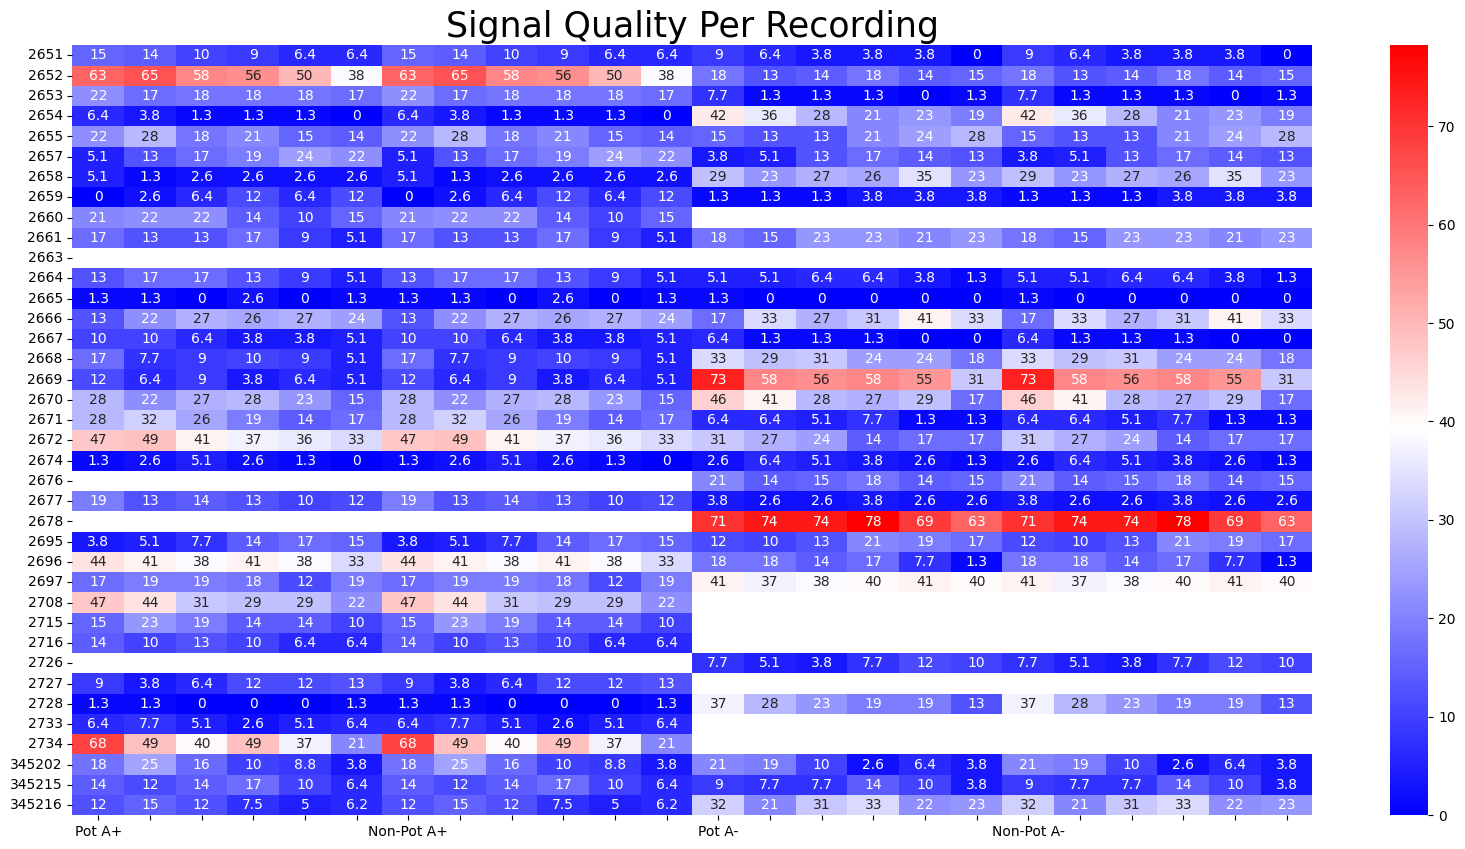

In [31]:
fig,axs = plt.subplots(figsize = (20,10))

axs.set_title(f'Signal Quality Per Recording',fontsize = 25)
sns.heatmap(All_NaN_MatData, annot=True, cmap='bwr', cbar=True, yticklabels = AllSubject_IDs,xticklabels=c_labels) # bwr'

<Axes: title={'center': 'Signal Quality Per Recording'}>

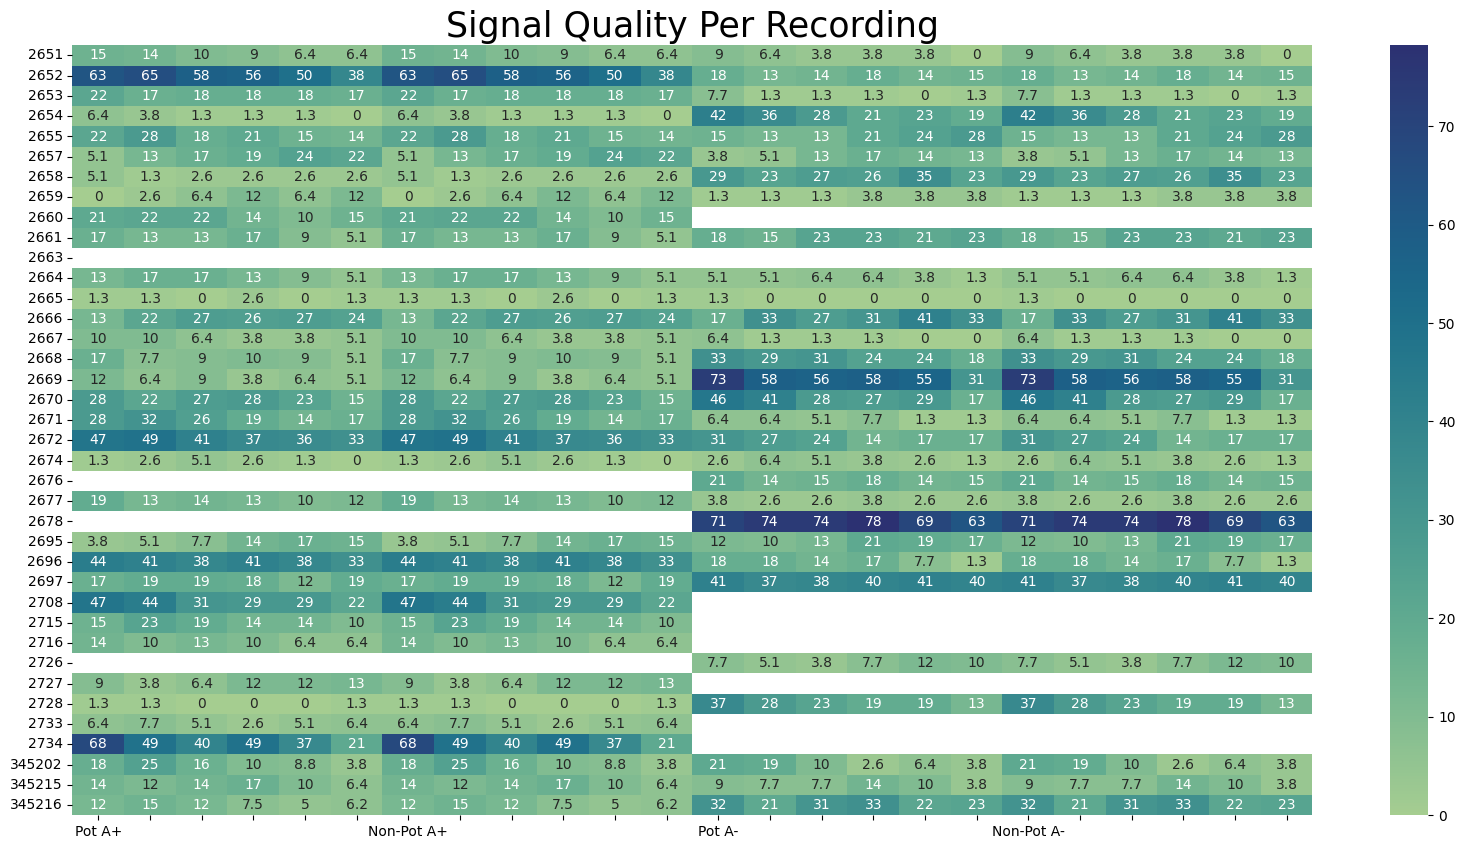

In [32]:
fig,axs = plt.subplots(figsize = (20,10))

axs.set_title(f'Signal Quality Per Recording',fontsize = 25)
sns.heatmap(All_NaN_MatData, annot=True, cmap='crest', cbar=True, yticklabels = AllSubject_IDs,xticklabels=c_labels) # bwr'